# Load in Data

In [2]:
from formulas import *
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

keras = tf.keras

### Update Data
To update the SPY.csv data uncomment all the lines of the cell below and rerun. If enough time has passed, you may want to look at changing the splits of the validation data, test data, and the train data.

In [43]:
# import yfinance as yf

# spy = yf.Ticker("SPY")

# # get stock info
# spy.info

# # get historical market data as df
# hist = spy.history(period="max")

# # Save df as CSV
# hist.to_csv('SPY.CSV')

In [3]:
# Read data in to dataframes
spy = pd.read_csv('SPY.csv')
# dia = pd.read_csv('etfs/DIA.csv')
# qqq = pd.read_csv('etfs/QQQ.csv')


# Change date column to datetime type
spy['Date'] = pd.to_datetime(spy['Date'])
# dia['Date'] = pd.to_datetime(dia['Date'])
# qqq['Date'] = pd.to_datetime(qqq['Date'])

# # View amount of daily data
# print(f'There are {spy.shape[0]} rows in SPY and {dia.shape[0]} DIA rows')
# print('*'*100)
# print(f'''The date range of SPY is {spy.index.min()} to {spy.index.max()} 
#        \n DIA is {dia.index.values.min()} to {dia.index.max()}
#        \n QQQ is {qqq.index.min()} to {qqq.index.max()}''')

### SPY Train Test Split

Here we can see our complete plot in terms of time steps. Our entire data set is just shy of 7000 time steps. We know that our data is in days, so our data is just shy of 7000 daily observations. We need to separate out a training and validation set to see how our model holds up.

I will be choosing an arbitrary date to separate the training, validation, and test data.

In [4]:
series = spy['Close']

# Create train data set
train_split_date = '2014-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

5521 5522 6527 6528 6947


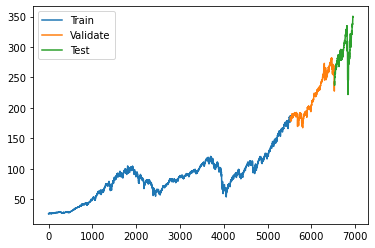

In [16]:
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [82]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting

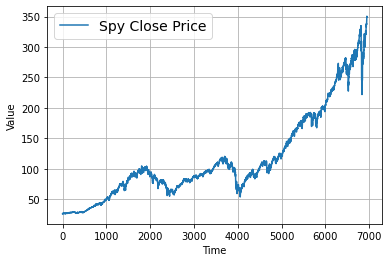

In [18]:
plot_series(time=spy.index,series=spy['Close'], label = 'Spy Close Price')

In [19]:
naive_forecast = series[test_split_index-1 :-1]

Text(0.5, 1.0, 'Naive Forecast vs Actual')

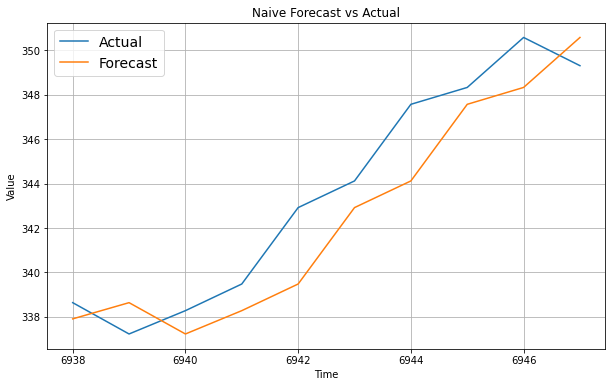

In [20]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index[-10:], x_test[-10:], label="Actual")
plot_series(x_test.index[-10:], naive_forecast[-10:], label="Forecast")
plt.title('Naive Forecast vs Actual')

### Calculate Error in Naive Model

In [83]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = keras.metrics.mean_absolute_error(x_test, naive_forecast).numpy()
model_mae_scores['naive'] = naive_forecast_mae
model_mae_scores

{'naive': 2.7155714285714283}

In [22]:
# Show first 3 values of our forecast
print(naive_forecast.values[:3])

# Show first 3 values of validation data
print(x_test.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast[:3].values - x_test[:3].values))

[242.77 243.03 237.23]
[243.03 237.23 245.17]
****************************************************************************************************
[0.26 5.8  7.94]


### Add MAE score to our dictionary

In [23]:
model_mae_scores

{}

# Monthly Moving Average Model (20 Day MA)

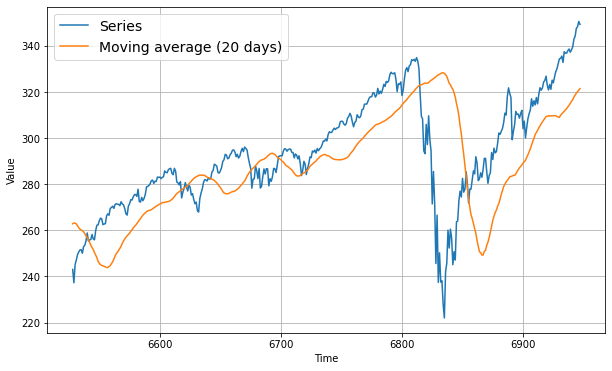

In [24]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = spy['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:spy.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (20 days)")

In [84]:
ma_20 = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()

model_mae_scores['SMA 20'] = ma_20
model_mae_scores

{'naive': 2.7155714285714283, 'SMA 20': 6.720838095237892}

# Weekly Moving Average (5 day MA)

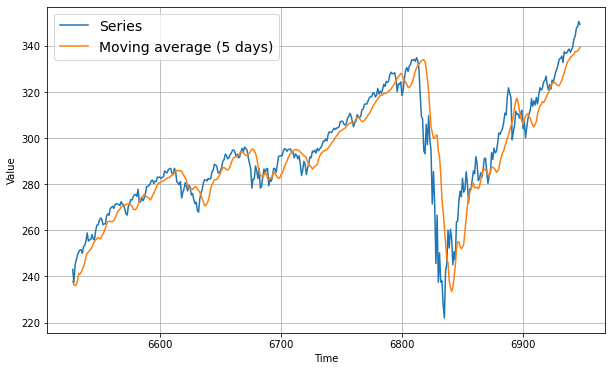

In [30]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = spy['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:spy.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (5 days)")

In [85]:
# Calculate MAE
ma_5 = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['SMA 5'] = ma_5
model_mae_scores

{'naive': 2.7155714285714283,
 'SMA 20': 6.720838095237892,
 'SMA 5': 6.720838095237892}

# ARIMA

### Step 1: Is the data stationary?

Use Augmented Dickey Fuller test to determine if the data is stationary
- Failure to reject the null hypothesis means the data is not stationary

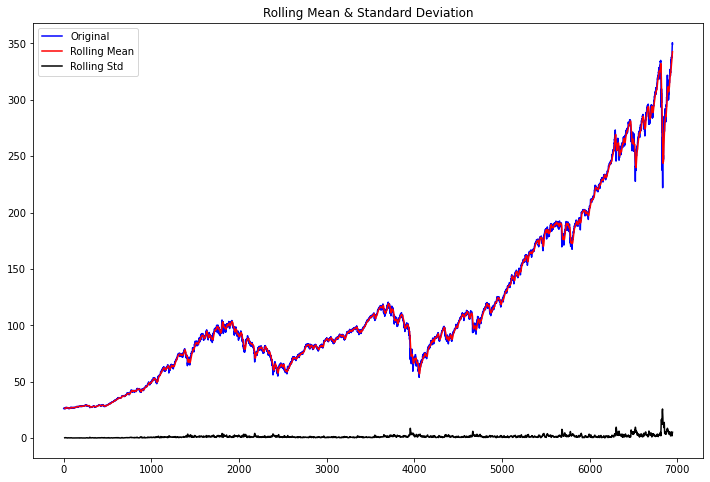

Results of Dickey-Fuller Test:
p-value = 0.9981. The series is likely non-stationary.
Test Statistic                    1.697982
p-value                           0.998124
#Lags Used                       20.000000
Number of Observations Used    6927.000000
Critical Value (1%)              -3.431294
Critical Value (5%)              -2.861957
Critical Value (10%)             -2.566992
dtype: float64


In [32]:
test_stationarity(series)

The **p-value is obtained is greater than significance level of 0.05** and the **ADF statistic is higher than any of the critical values.**

Clearly, there is no reason to reject the null hypothesis. **So, the time series is in fact non-stationary.** Since our data is not statio

### Step 2 Differencing
We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference.

In [33]:
# Get the difference of each Adj Close point
spy_close_diff_1 = series.diff()
spy_close_diff_1.dropna(inplace=True)

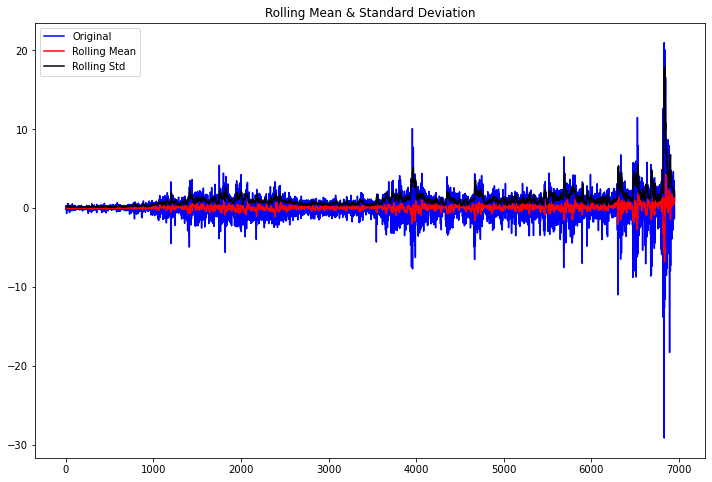

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.852899e+01
p-value                        2.104220e-30
#Lags Used                     1.900000e+01
Number of Observations Used    6.927000e+03
Critical Value (1%)           -3.431294e+00
Critical Value (5%)           -2.861957e+00
Critical Value (10%)          -2.566992e+00
dtype: float64


In [34]:
# Plot the spy Adj Close 1st order difference
test_stationarity(spy_close_diff_1)

The **p-value is obtained is less than significance level of 0.05** and the **ADF statistic is lower than any of the critical values.**

We reject the null hypothesis. **So, the time series is in fact stationary.** 

### Step 3 Autocorrelation and Partial autocorrelation

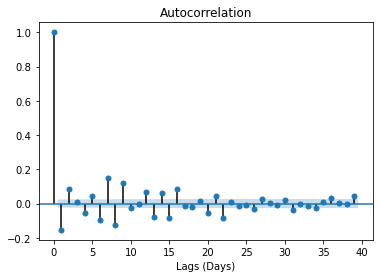

In [36]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(spy_close_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

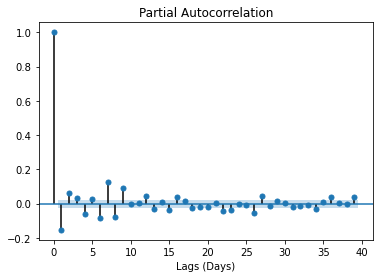

In [37]:
plot_pacf(spy_close_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

In [70]:
# Establish empty list for for-loop
spy_autocorr = []

# Loop through lag numbers to find the point with highest autocorrelation
for x in list(range(1,101)):
    spy_autocorr.append(spy_close_diff_1.autocorr(lag=x))

# Show the index of the point with the largest autocorrelation value
# 0 indexed so add 1 for correct number of lags
lags = spy_autocorr.index(max(spy_autocorr)) + 1 
print('The best performing lag is number {}'.format(lags))

The best performing lag is number 7


### Testing different arima models

In [83]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
spy_arima = ARIMA(x_train, order=(1,1,1))
spy_arima_fit = spy_arima.fit(disp=0)
print(spy_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 5521
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7864.841
Method:                       css-mle   S.D. of innovations              1.006
Date:                Tue, 01 Sep 2020   AIC                          15737.682
Time:                        00:31:02   BIC                          15764.148
Sample:                             1   HQIC                         15746.912
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0287      0.011      2.566      0.010       0.007       0.051
ar.L1.D.Close     0.6402      0.089      7.179      0.000       0.465       0.815
ma.L1.D.Close    -0.7027      0.083     

NormaltestResult(statistic=863.6353376774764, pvalue=2.910510933059743e-188)
This distribution is not a normal distribution


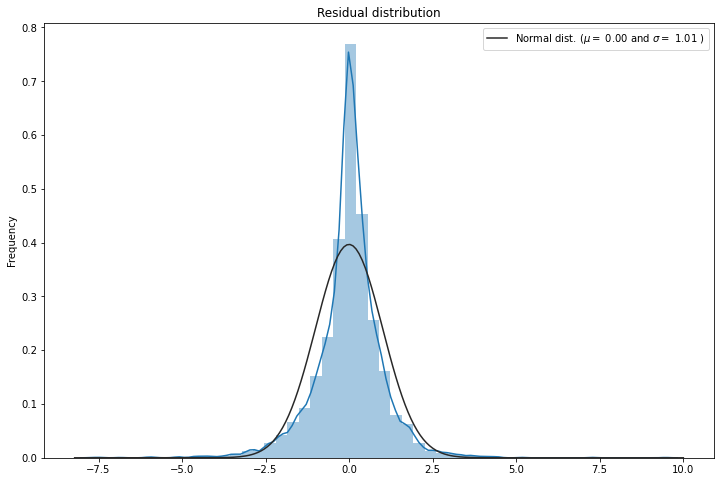

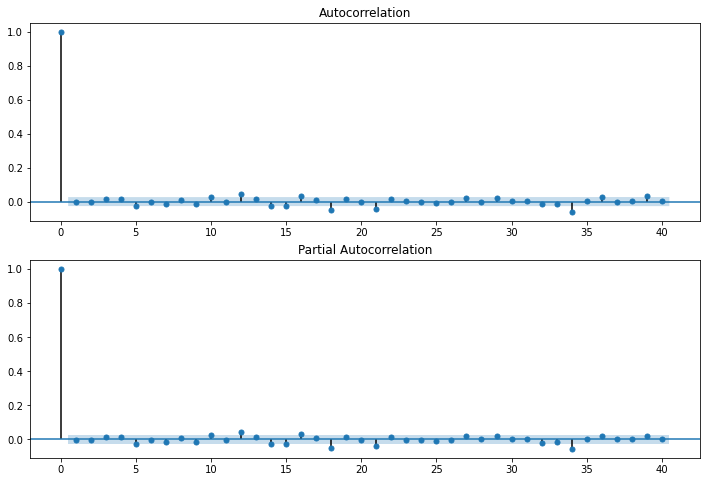

In [84]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = spy_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

### Step 4 Building the Arima Model and Forecasting

In [85]:
history = [x for x in x_train]
model_predictions = []
N_test_observations = len(x_test)


for time_point in list(x_test.index):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
MAE_error = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

Testing Mean Squared Error is 6.720838095237892
Stored 'model_predictions' (list)


In [39]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[array([184.5022509]),
 array([238.13209089]),
 array([234.90574724]),
 array([244.28651455]),
 array([247.0566748])]

In [40]:
#save model
model_fit.save('arima_111.pkl')

# Load model
from statsmodels.tsa.arima.model import ARIMAResults
loaded = ARIMAResults.load('arima_111.pkl')

NameError: name 'model_fit' is not defined

In [86]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA'] = arima_mae
model_mae_scores

{'naive': 2.7155714285714283,
 'SMA 20': 6.720838095237892,
 'SMA 5': 6.720838095237892,
 'ARIMA': 2.788394590315775}

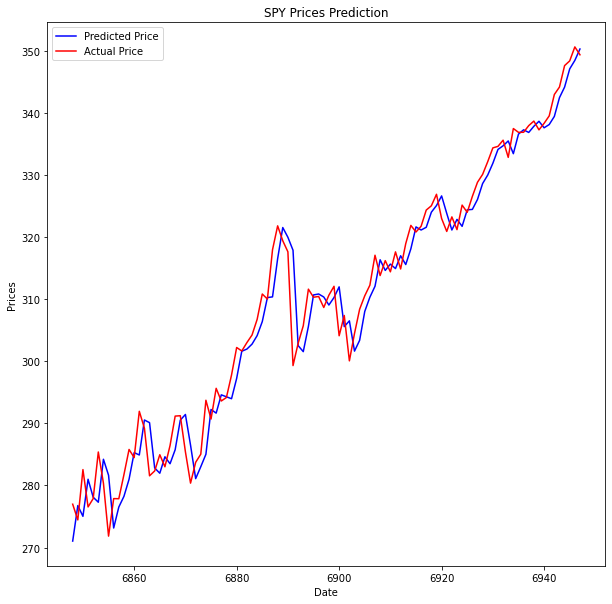

<Figure size 720x432 with 0 Axes>

In [42]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(x_test.index[-100:], model_predictions[-100:], color='blue',label='Predicted Price')
plt.plot(x_test.index[-100:], x_test[-100:], color='red', label='Actual Price')
plt.title('SPY Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
# plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [113]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

#### Show Error in model vs actual

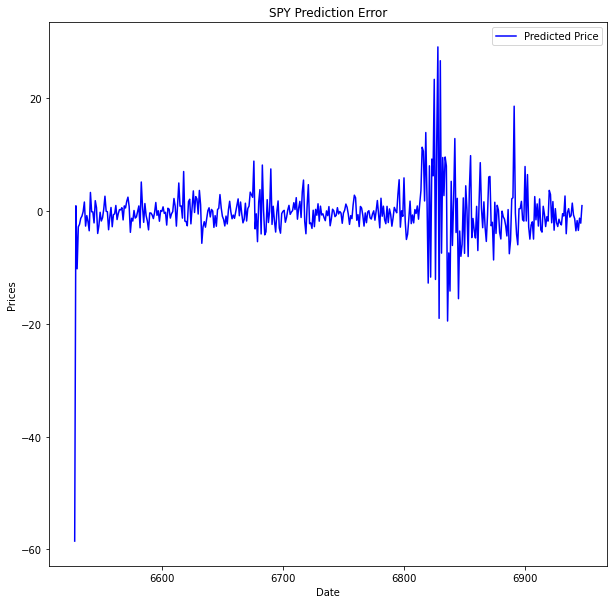

<Figure size 720x432 with 0 Axes>

In [116]:
plt.plot(x_test.index, arima_error, color='blue',label='Predicted Price')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('SPY Prediction Error')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Deep Learning

## Single Dense Neuron Linear Model

## Dense Forecast

## Simple RNN Model 

### Seq to Vec RNN Model 

#### Data

In [118]:
# Reshape values
x_train_values = x_train.values.reshape((len(x_train), 1))
x_valid_values = x_valid.values.reshape((len(x_valid), 1))

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))
x_valid_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_valid_scaler.fit_transform(x_valid_values)

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

#### Learning Rate

In [119]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 100

# create windowed tensor data set from series
train_set = window_dataset(x_train, window_size, batch_size=512)

# Create RNN model
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Changes from 2D data to 3D (batch size, time, dimensionality per time step)
                      input_shape=[None]), # this  accepts windows of any shape
  
  keras.layers.SimpleRNN(100, return_sequences=True), # create RNN with 100 neurons
  keras.layers.SimpleRNN(100), # takes in sequence from previous layer outputs vector with 100 dimensions
  keras.layers.Dense(1), # Dense layer to make prediction
  ]) 

# Maps learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.Nadam(lr=1e-7)
model.compile(loss=keras.losses.Huber(),
              optimizer= optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=125, callbacks=[lr_schedule])


Epoch 1/125
11/11 [==============================] - 1s 121ms/step - loss: 84.5010 - mae: 85.0010
Epoch 2/125
11/11 [==============================] - 1s 120ms/step - loss: 84.4994 - mae: 84.9994
Epoch 3/125
11/11 [==============================] - 1s 107ms/step - loss: 84.4974 - mae: 84.9974
Epoch 4/125
11/11 [==============================] - 1s 104ms/step - loss: 84.4951 - mae: 84.9951
Epoch 5/125
11/11 [==============================] - 1s 104ms/step - loss: 84.4925 - mae: 84.9925
Epoch 6/125
11/11 [==============================] - 1s 104ms/step - loss: 84.4895 - mae: 84.9895
Epoch 7/125
11/11 [==============================] - 1s 105ms/step - loss: 84.4862 - mae: 84.9862
Epoch 8/125
11/11 [==============================] - 1s 104ms/step - loss: 84.4825 - mae: 84.9825
Epoch 9/125
11/11 [==============================] - 1s 105ms/step - loss: 84.4783 - mae: 84.9783
Epoch 10/125
11/11 [==============================] - 1s 105ms/step - loss: 84.4736 - mae: 84.9736
Epoch 11/125
11/11 

(1e-07, 1.0, 0.0, 100.0)

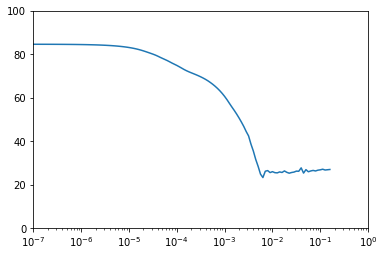

In [120]:
# Plot Learning Rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1, 0, 100])

#### Model Train

In [121]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 20

# create windowed tensor data set from series
train_set = window_dataset(x_train, window_size, batch_size=512)
valid_set = window_dataset(x_valid, window_size, batch_size=512)


# Create RNN model
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Changes from 2D data to 3D (batch size, time, dimensionality per time step)
                      input_shape=[None]), # this  accepts windows of any shape
  keras.layers.SimpleRNN(100, return_sequences=True), # create RNN with 100 neurons
  keras.layers.SimpleRNN(100), # takes in sequence from previous layer outputs vector with 100 dimensions
  keras.layers.Dense(1), # Dense layer to make prediction
  ]) 

# # Set optimizer
optimizer = keras.optimizers.Nadam(lr=7e-3)

#compile model choose metric and loss function
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=10)

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# fit model to data
model.fit(train_set, epochs=1000,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/1000
      9/Unknown - 0s 54ms/step - loss: 66.0313 - mae: 66.5313WARNING:tensorflow:From C:\Users\blake\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_checkpoint\assets
11/11 [==============================] - 2s 224ms/step - loss: 72.2486 - mae: 72.7486 - val_loss: 200.6348 - val_mae: 201.1348
Epoch 2/1000
11/11 [==============================] - 2s 193ms/step - loss: 63.0356 - mae: 63.5356 - val_loss: 193.1898 - val_mae: 193.6898
Epoch 3/1000
11/11 [==============================] - 2s 196ms/step - loss: 55.5089 - mae: 56.0059 - val_loss: 185.5229 - val_m

#### Make Predictions

In [122]:
model = keras.models.load_model("my_checkpoint")

In [126]:
rnn_forecast = model_forecast(
    model,
    series[x_test.index.min() - window_size:-1],
    window_size)[:, 0]

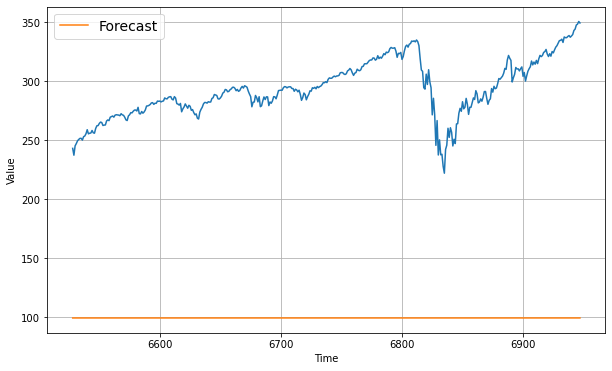

In [127]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test)
plot_series(x_test.index, rnn_forecast, label = 'Forecast')


In [131]:
rnn_forecast_mae = keras.metrics.mean_absolute_error(x_test, rnn_forecast).numpy()
rnn_forecast_mae

193.68008

### Seq to Seq RNN

#### Data

In [101]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

#### Learning Rate Finder

In [96]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 100

# create windowed tensor data set from series
train_set = window_dataset(normalized_x_train, window_size, batch_size=512)

# Create RNN model
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
])


# Maps learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))

optimizer = keras.optimizers.Nadam(lr=1e-7)


model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
11/11 [==============================] - 1s 115ms/step - loss: 0.0990 - mae: 0.3702
Epoch 2/100
11/11 [==============================] - 1s 111ms/step - loss: 0.0637 - mae: 0.2783
Epoch 3/100
11/11 [==============================] - 1s 113ms/step - loss: 0.0426 - mae: 0.2113
Epoch 4/100
11/11 [==============================] - 1s 113ms/step - loss: 0.0321 - mae: 0.1764
Epoch 5/100
11/11 [==============================] - 1s 111ms/step - loss: 0.0264 - mae: 0.1591
Epoch 6/100
11/11 [==============================] - 1s 113ms/step - loss: 0.0216 - mae: 0.1413
Epoch 7/100
11/11 [==============================] - 1s 111ms/step - loss: 0.0175 - mae: 0.1240
Epoch 8/100
11/11 [==============================] - 1s 113ms/step - loss: 0.0145 - mae: 0.1132
Epoch 9/100
11/11 [==============================] - 1s 112ms/step - loss: 0.0122 - mae: 0.1054
Epoch 10/100
 1/11 [=>............................] - ETA: 0s - loss: 0.0053 - mae: 0.0792

KeyboardInterrupt: 

In [102]:
# Plot Learning Rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1, 0, .05])

NameError: name 'history' is not defined

#### Train Model

In [103]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 100
train_set = window_dataset(normalized_x_train, window_size, batch_size=512)
valid_set = window_dataset(normalized_x_valid, window_size, batch_size=512)


# Create RNN model
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
])

# Set optimizer
optimizer = keras.optimizers.Nadam(lr=1e-4)

#compile model choose metric and loss function
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=20)

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# fit model to data
model.fit(train_set, epochs=1000,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/1000
     11/Unknown - 1s 112ms/step - loss: 0.0547 - mae: 0.2303WARNING:tensorflow:From C:\Users\blake\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_checkpoint\assets
11/11 [==============================] - 3s 289ms/step - loss: 0.0547 - mae: 0.2303 - val_loss: 0.4779 - val_mae: 0.9294
Epoch 2/1000
11/11 [==============================] - 3s 291ms/step - loss: 0.0225 - mae: 0.1533 - val_loss: 0.2487 - val_mae: 0.6343
Epoch 3/1000
11/11 [==============================] - 3s 272ms/step - loss: 0.0112 - mae: 0.1035 - val_loss: 0.1596 - val_mae: 0.4996
Epoch 

11/11 [==============================] - 2s 166ms/step - loss: 0.0016 - mae: 0.0401 - val_loss: 0.0477 - val_mae: 0.2978
Epoch 40/1000
11/11 [==============================] - 2s 167ms/step - loss: 0.0015 - mae: 0.0415 - val_loss: 0.0088 - val_mae: 0.1003
Epoch 41/1000
11/11 [==============================] - 4s 331ms/step - loss: 0.0010 - mae: 0.0325 - val_loss: 0.0068 - val_mae: 0.0839
Epoch 42/1000
11/11 [==============================] - 4s 344ms/step - loss: 9.4382e-04 - mae: 0.0306 - val_loss: 0.0060 - val_mae: 0.0774
Epoch 43/1000
11/11 [==============================] - 2s 189ms/step - loss: 9.2444e-04 - mae: 0.0302 - val_loss: 0.0063 - val_mae: 0.0802
Epoch 44/1000
11/11 [==============================] - 2s 188ms/step - loss: 8.7450e-04 - mae: 0.0288 - val_loss: 0.0062 - val_mae: 0.0794
Epoch 45/1000
11/11 [==============================] - 2s 188ms/step - loss: 0.0010 - mae: 0.0323 - val_loss: 0.0154 - val_mae: 0.1548
Epoch 46/1000
11/11 [==============================] - 2s

Epoch 85/1000
11/11 [==============================] - 2s 202ms/step - loss: 9.3328e-04 - mae: 0.0311 - val_loss: 0.0074 - val_mae: 0.1053
Epoch 86/1000
11/11 [==============================] - 2s 202ms/step - loss: 9.4722e-04 - mae: 0.0325 - val_loss: 0.0044 - val_mae: 0.0722
Epoch 87/1000
11/11 [==============================] - 2s 204ms/step - loss: 8.6172e-04 - mae: 0.0300 - val_loss: 0.0051 - val_mae: 0.0827
Epoch 88/1000
11/11 [==============================] - 2s 203ms/step - loss: 9.2895e-04 - mae: 0.0320 - val_loss: 0.0063 - val_mae: 0.0943
Epoch 89/1000
11/11 [==============================] - 4s 340ms/step - loss: 8.0639e-04 - mae: 0.0295 - val_loss: 0.0033 - val_mae: 0.0595
Epoch 90/1000
11/11 [==============================] - 2s 191ms/step - loss: 7.8988e-04 - mae: 0.0287 - val_loss: 0.0035 - val_mae: 0.0613
Epoch 91/1000
11/11 [==============================] - 4s 351ms/step - loss: 7.3946e-04 - mae: 0.0269 - val_loss: 0.0032 - val_mae: 0.0585
Epoch 92/1000
11/11 [======

Epoch 133/1000
11/11 [==============================] - 2s 200ms/step - loss: 7.2183e-04 - mae: 0.0266 - val_loss: 0.0027 - val_mae: 0.0547
Epoch 134/1000
11/11 [==============================] - 2s 200ms/step - loss: 7.0820e-04 - mae: 0.0263 - val_loss: 0.0027 - val_mae: 0.0548
Epoch 135/1000
11/11 [==============================] - 2s 199ms/step - loss: 7.2770e-04 - mae: 0.0269 - val_loss: 0.0027 - val_mae: 0.0555
Epoch 136/1000
11/11 [==============================] - 2s 198ms/step - loss: 8.5562e-04 - mae: 0.0295 - val_loss: 0.0070 - val_mae: 0.1034
Epoch 137/1000
11/11 [==============================] - 2s 198ms/step - loss: 9.1075e-04 - mae: 0.0316 - val_loss: 0.0046 - val_mae: 0.0803
Epoch 138/1000
11/11 [==============================] - 4s 358ms/step - loss: 7.5160e-04 - mae: 0.0275 - val_loss: 0.0025 - val_mae: 0.0525
Epoch 139/1000
11/11 [==============================] - 4s 344ms/step - loss: 7.0928e-04 - mae: 0.0263 - val_loss: 0.0025 - val_mae: 0.0522
Epoch 140/1000
11/11

11/11 [==============================] - 3s 227ms/step - loss: 7.2477e-04 - mae: 0.0268 - val_loss: 0.0025 - val_mae: 0.0542
Epoch 185/1000
11/11 [==============================] - 3s 228ms/step - loss: 7.1403e-04 - mae: 0.0262 - val_loss: 0.0036 - val_mae: 0.0683
Epoch 186/1000
11/11 [==============================] - 2s 226ms/step - loss: 7.1915e-04 - mae: 0.0268 - val_loss: 0.0024 - val_mae: 0.0514
Epoch 187/1000
11/11 [==============================] - 4s 356ms/step - loss: 7.0492e-04 - mae: 0.0260 - val_loss: 0.0023 - val_mae: 0.0502
Epoch 188/1000
11/11 [==============================] - 2s 213ms/step - loss: 6.9431e-04 - mae: 0.0257 - val_loss: 0.0023 - val_mae: 0.0505
Epoch 189/1000
11/11 [==============================] - 4s 354ms/step - loss: 7.0021e-04 - mae: 0.0260 - val_loss: 0.0022 - val_mae: 0.0498
Epoch 190/1000
11/11 [==============================] - 2s 194ms/step - loss: 6.9202e-04 - mae: 0.0257 - val_loss: 0.0024 - val_mae: 0.0517
Epoch 191/1000
11/11 [=============

In [104]:
model = keras.models.load_model("my_checkpoint")

#### Make Predictions

In [105]:
rnn_forecast = model_forecast(model, spy_normalized_to_traindata, window_size)
rnn_forecast = rnn_forecast[x_test.index.min() - window_size:-1, -1, 0]

In [106]:
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast[:5]

array([244.94974, 245.11728, 241.80109, 246.69682, 247.29872],
      dtype=float32)

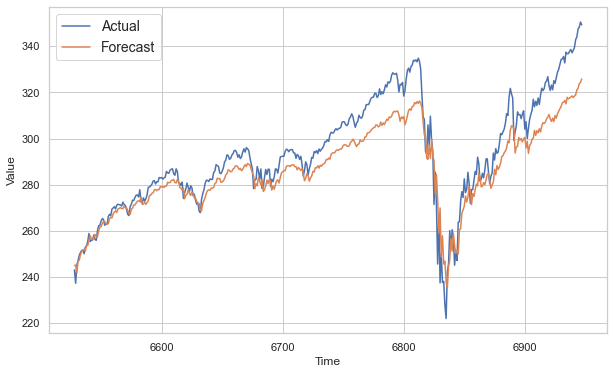

In [107]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")


In [108]:
# Alternative way to show MAE to stay consistent with what we will be doing later
rnn_mae = keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['rnn_mae'] = rnn_mae
model_mae_scores

{'naive': 2.7155714285714283,
 'SMA 20': 6.720838095237892,
 'SMA 5': 6.720838095237892,
 'ARIMA': 2.788394590315775,
 'rnn_mae': 8.0879135}

## LSTM Model

## Preprocessing with 1-D CNN for RNN Model

## CNN - Wavenet Model

# Summary of Model Results

In [109]:
model_mae_scores['full_cnn'] = 2.7002285
model_mae_scores['pre-process_cnn'] = 15.290731
model_mae_scores['linear_model'] = 3.6513362
model_mae_scores['dense'] = 9.137429
model_mae_scores['lstm'] = 1.3871188

%store model_mae_scores

Stored 'model_mae_scores' (dict)


In [110]:
mae_series = pd.Series(model_mae_scores)

In [111]:
model_mae_scores

{'naive': 2.7155714285714283,
 'SMA 20': 6.720838095237892,
 'SMA 5': 6.720838095237892,
 'ARIMA': 2.788394590315775,
 'rnn_mae': 8.0879135,
 'full_cnn': 2.7002285,
 'pre-process_cnn': 15.290731,
 'linear_model': 3.6513362,
 'dense': 9.137429,
 'lstm': 1.3871188}

In [128]:
order = mae_series.sort_values()

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.]),
 <a list of 10 Text major ticklabel objects>)

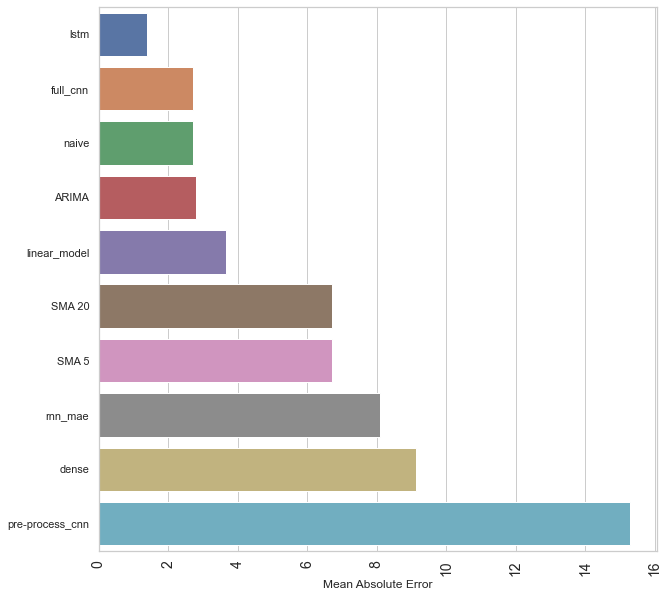

In [136]:
sns.set(style="whitegrid")
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
